<a href="https://colab.research.google.com/github/tonmoy-khanal/Crypto-Currency-Price-Prediction/blob/main/price_prediction_bitcoin(LSTM).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
%tensorflow_version 2.x
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
%matplotlib inline

In [6]:
endpoint = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(endpoint + '?fsym=BTC&tsym=CAD&limit=500')
hist = pd.DataFrame(json.loads(res.content)['Data'])
hist = hist.set_index('time')
hist.index = pd.to_datetime(hist.index, unit='s')
target_col = 'close'

In [7]:
hist.drop(["conversionType", "conversionSymbol"], axis = 'columns', inplace = True)

In [8]:
hist.head(5)

,high,low,open,volumefrom,volumeto,close
time,,,,,,
2020-12-13,24864.39,24020.59,24155.59,63.47,1558747.61,24531.30
2020-12-14,24721.62,24311.51,24531.30,40.50,993183.24,24663.80
2020-12-15,24964.65,24313.69,24663.80,81.42,2014729.81,24778.67
2020-12-16,27554.68,24607.81,24778.67,200.93,5265256.22,27337.58
2020-12-17,30240.45,27240.89,27337.58,262.97,7563315.76,29133.10


In [9]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [10]:
train, test = train_test_split(hist, test_size=0.2)

In [11]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [CAD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

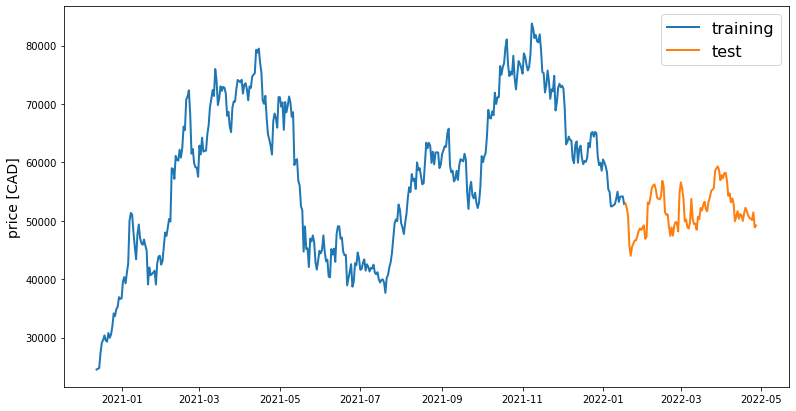

In [12]:
line_plot(train[target_col], test[target_col], 'training', 'test', title='')

In [13]:
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (data.max() - df.min())

In [14]:
def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [15]:
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [16]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [17]:
np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 20
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [18]:
train, test, X_train, X_test, y_train, y_test = prepare_data(
    hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [19]:
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/20
13/13 [==============================] - 3s 52ms/step - loss: 0.0090 - val_loss: 0.0034
Epoch 2/20
13/13 [==============================] - 0s 9ms/step - loss: 0.0076 - val_loss: 0.0028
Epoch 3/20
13/13 [==============================] - 0s 9ms/step - loss: 0.0044 - val_loss: 0.0036
Epoch 4/20
13/13 [==============================] - 0s 9ms/step - loss: 0.0085 - val_loss: 0.0036
Epoch 5/20
13/13 [==============================] - 0s 9ms/step - loss: 0.0042 - val_loss: 0.0034
Epoch 6/20
13/13 [==============================] - 0s 10ms/step - loss: 0.0047 - val_loss: 0.0029
Epoch 7/20
13/13 [==============================] - 0s 9ms/step - loss: 0.0042 - val_loss: 0.0019
Epoch 8/20
13/13 [==============================] - 0s 10ms/step - loss: 0.0047 - val_loss: 0.0023
Epoch 9/20
13/13 [==============================] - 0s 10ms/step - loss: 0.0062 - val_loss: 0.0020
Epoch 10/20
13/13 [==============================] - 0s 9ms/step - loss: 0.0040 - val_loss: 0.0018
Epoch 11/20
13/

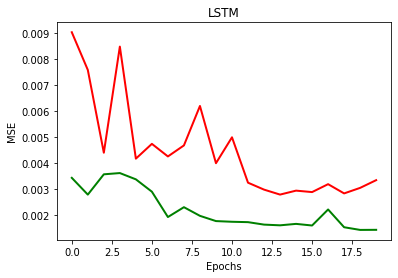

In [20]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],'r',linewidth=2, label='Train loss')
plt.plot(history.history['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('LSTM')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

In [21]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

0.028979315780118496

In [22]:
from sklearn.metrics import mean_squared_error
MAE=mean_squared_error(preds, y_test)
MAE


0.0014224611274349602

In [23]:
from sklearn.metrics import r2_score
R2=r2_score(y_test, preds)
R2

0.7045075334988304

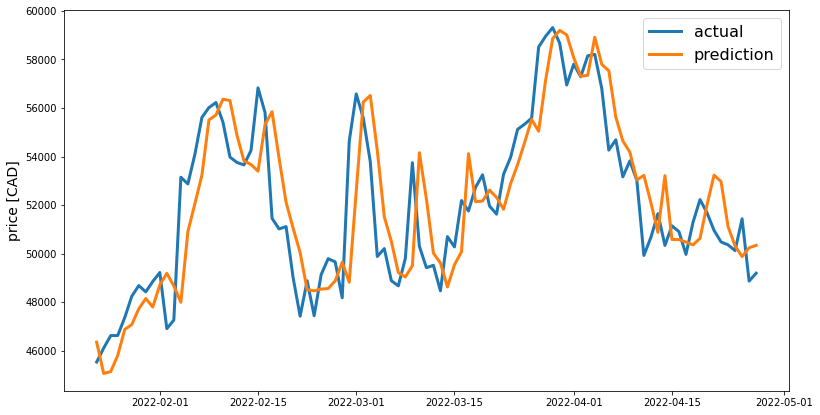

In [24]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)